# Homework 4 - Parallelism
### Sam Badman - 2/28/18

__Task :__ To run a Monte Carlo dart-throwing simulation to approximate $\pi$ in serial, with multiprocessing and with the ipyparallel module, to investigate the execution time improvements due to the parallelization

* Write a program to run the algorithm under the three different parallelization methods.

* Run trials with different darts thrown

* Keep track of execution times as a function of number of darts and method of parallelization

* Keep track of simulation rate (darts thrown per second)

* [Optional :] Run each sim multiple times to get statistics on execution time and simulation rate

* Plot execution time and simulation rate as a function of number of darts for each method ( + errorbar plots if standard deviation calculated)

* Emulate style of example plot in hw_4_parallelism.pdf pg 4.

* Explain the behavior you measure and illustrate in the plot.

* Grader should be able to run the submitted program and reproduce the plot

__The Simulation__

We throw a dart onto a square board of (x,y) coordinates in the range [-0.5,0.5],[-0.5,0.5] i.e. centered at the origin. A given dart event is an instance in which x and y are independently samples from these ranges. 

The result of this dart throw is then tested against the condition of whether it lies inside a circle of radius 0.5 inset at the center of a unit square board

$$ (x^2 + y^2) <= 0.5^2 $$.

$N$ darts are thrown, and the number of darts satisfying the above condition, $x$, is kept track of. The fraction of these two numbers in the limit of a large number of darts is approximately the ratio of the area of the circle to the area of a unit square which is $\pi/4$. Therefore, our approximation to $\pi$ is 

$$
\boxed{\pi = \frac{4x}{N}}
$$

In [1]:
# Import all required modules except plotting
from time import time, sleep
from math import sqrt
import multiprocessing as mp
import ipyparallel as ipp

To start with, define a function that throws N darts and returns the number which land within the inscribed circle.

In [2]:
# Implement the random generation of x-y coordinates 
# and assessment of whether that number lies within the inset circle
def throw_dart(a) :
    from random import uniform
    x,y = uniform(-0.5,0.5),uniform(-0.5,0.5)
    return (x**2 + y**2) < 0.25

Next, define a function which runs the algorithm in serial for a given input number of darts $N$ to throw and returns the final approximation to $\pi$

In [3]:
## Define a function to run the algorithm in serial
def pi_approx_serial(N) :
    '''
    Argument : N - [int] number of darts to throw to approximate pi
    Return : [float] point approximation to pi
    '''
    x = 0
    t1 = time()
    for a in range(N) :
        # If dart lands in circle, add to the count of darts inside circle
        if throw_dart(a) : x += 1
    pi = 4.*x/N
    t2 = time() 
    return pi, t2-t1

Now, begin to parallelize this process. First identify the number of cores available on this machine.

In [4]:
n_cpus = mp.cpu_count()
print("Number of cpu cores on this machine is : "+str(n_cpus))

Number of cpu cores on this machine is : 8


Next, define a function to calculate the above algorithm using python multiprocessing.

In [5]:
def pi_approx_mp(N,n_cpus) :
    '''
    Argument : N - [int] number of darts to throw to approximate pi
    Return : [float] approximation to pi
    '''
    # Use multiprocessing.Pool to initialize a number of processes equal to the 
    # number of cores on your computer
    pool = mp.Pool(processes=n_cpus)
    t1 = time()
    # Map to a list every true or false value returned from the throw_dart() function
    hits_and_misses = pool.map(throw_dart,range(N))
    pi = 4.*sum(hits_and_misses)/len(hits_and_misses)
    t2 = time()
    pool.close()
    pool.join()
    return pi, t2-t1

And a function to repeat but using ipyparallel

In [6]:
def pi_approx_ipp(N) :
    '''
    Argument : N - [int] number of darts to throw to approximate pi
    Return : [float] approximation to pi
    '''
    # Start an IPyparallel client
    c = ipp.Client()
    # Create a DirectView object
    c_view = c[:]
    # Map the True and Falses from throw_dart() to a list
    t1 = time()
    hits_and_misses = c_view.map_sync(throw_dart,range(N))
    pi = 4.*sum(hits_and_misses)/len(hits_and_misses)
    t2 = time()
    return pi, t2 - t1

Finally, write a scipt which iterates through different values of N, times the algorithm's performance with each method of parallelization, and returns the total run time and run time per "dart throw".

In [7]:
# List of number of dart throws to be iterated over
N = [int(10**i) for i in range(1,8)]
         
# List of times to be plotted
serial_time = []
mp_time = []
ipp_time = []

# First run in serial for each N, and get the run time to produce the 
# pi approximation for each value of N
print("Running in serial...")
for n in N : 
    pi_s,t_s = pi_approx_serial(n)
    serial_time.append(t_s)
    
# Second, run in parallel with multiprocessing and get run times
print("Running with multiprocessing...")
for n in N :
    pi_mp,t_mp = pi_approx_mp(n,n_cpus)
    mp_time.append(t_mp)
    
# Finally, run in parallel with Ipyparallel and get run times    
print("Running with Ipyparallel...")
# Start the "cluster" locally
print("Initializing Cluster...")
start_cluster_string = "ipcluster start -n "+str(n_cpus)
import os
os.popen(start_cluster_string)
# sleep command ensures computer has enough time to initialize the cluster
# before it is attempted to me accessed by ipp
sleep(10)
print("Cluster up and running")
for n in N :
    pi_ipp,t_ipp = pi_approx_ipp(n)
    ipp_time.append(t_ipp)   
print("Closing cluster")
# close the cluster
os.popen("ipcluster stop")

# Divide N by the corresponding time to get number of darts thrown per second
# i.e. simulation rate
import numpy as np
serial_sim_rate = [rate for rate in list(np.array(N)/np.array(serial_time))]
mp_sim_rate = [rate for rate in list(np.array(N)/np.array(mp_time))]
ipp_sim_rate = [rate for rate in list(np.array(N)/np.array(ipp_time))]
print("Done")

Running in serial...
Running with multiprocessing...
Running with Ipyparallel...
Initializing Cluster...
Cluster up and running


/home/samuel_badman/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@sam-Oryx-Pro')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)
/home/samuel_badman/anaconda3/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@sam-Oryx-Pro')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Closing cluster
Done


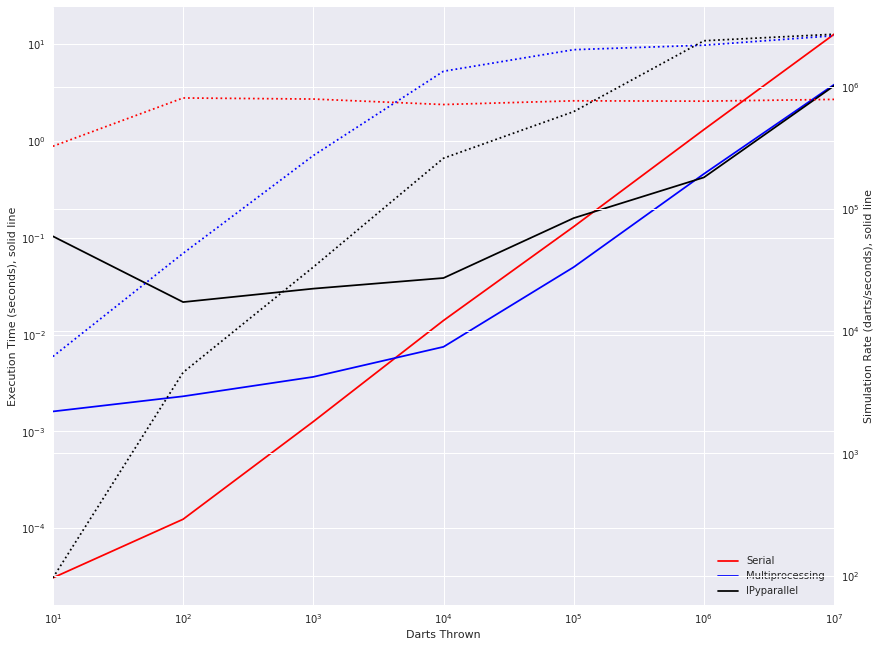

In [8]:
# Plot the results, with the left y-axis for runtime and
# the right y-axis for simulation rate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
fig = plt.figure(figsize=(14,11))
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Darts Thrown")
ax1.set_ylabel("Execution Time (seconds), solid line")
ax1.set_xlim([N[0],N[-1]])
ax1.loglog(N,serial_time,color="red",label="Serial")
ax1.loglog(N,mp_time,color="blue",label="Multiprocessing")
ax1.loglog(N,ipp_time,color ="black",label="IPyparallel")
ax2 = ax1.twinx()
ax2.set_ylabel("Simulation Rate (darts/seconds), solid line")
ax2.loglog(N,serial_sim_rate,color="red",linestyle=":")
ax2.loglog(N,mp_sim_rate,color="blue",linestyle=":")
ax2.loglog(N,ipp_sim_rate,color="black",linestyle=":")
ax1.legend(loc=4)

__Conclusions__

My machine is a Linux machine with 8 cores on an i7 Intel 2.8 GHz Chip 

We can see the same heuristic features as in the example plots in the homework pdf : the __parallelization is only advantageous as the number of darts thrown gets very large__. At small dart throws, the simple serial implementation is much faster as the __parallelization methods require overhead time to set up communication__ between processes / cores. We see that as the number of cores increases, the efficiency of the multiprocessing technique surpasses the serial technique at around $10^3$ darts, and the IPcluster method catches up soon after at around $10^5$ darts. Beyond $10^6$ darts, the IPCluster and Multiprocessing methods converge to around the same time. For all three techniques, the behaviour __at large numbers of darts is roughly linear in log-log space__ (exponential growth in linear space), but the parallel techniques log-log linear graph has a significantly lower execution time intercept, meaning the real time run times are much lower when we make use of parallelization. For example, at $10^7$ darts, the serial method takes around 14s to run on my machine, compared to around 4s with the two parallelized methods. This is because I give the program N tasks to do, and the __parallel techniques allow N/number of processes to be computed simultaneously__. In the limit where the time for completion in serial is much greater than the overhead time required for the parallel processes to communicate with each other, this means the parallelized times are much faster.

Comparing to the example plots, there is some discrepancy between the performance of IPCluster at the lowest dart numbers (N=10) - on my computer this consistently takes around 10x longer than the examples. The multiprocessing is also fractionally slower at low dart numbers, but otherwise there is very good agreement between my plot and the example, especially as number of darts gets very large. I'm not sure why this discrepancy in IPCluster run time exists but given where in my code I am timing I know it is not due to setting up the clusters or instantiating the client, so the difference must be happening in the map_sync function, and given the low computational requirement with 10 darts, the time is presumably coming from communicating with the engines.